# 1.4  Регуляризация 

In [257]:
import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib.pyplot as plt

### Функции вычисления коэффициентов разложения

In [258]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast (x, y, m):
    global G, Phi
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastRegRidge (x, y, m, alpha):
    
    # polinomial approximation with L2 (Tikhonov) regularization
    # x, y - data set
    # m - polinom degree 

    # Полиномиальная аппроксимация с L2 (Ridge) регуляризацией
    # alpha - параметр регуляризации, уменьшает переобучение
    
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a


def SqLeastRegLasso (x, y, m, alpha):
    
    # polinomial approximation with L1 (lasso) regularization
    # x, y - data set
    # m - number of basis functions (polinom degree + 1)
    
    global G, Phi
    
    n = len(x)
    yr = np.eye (n)
    E = np.eye (n)
    W = np.eye (m+1)
    
    
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    # initial stage
          
    G = PhiT @ Phi 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    yr = y @ E 
    
    eps = 0.001
    
    # iteration procedure
    
  #  print ()
  #  print ('Итерационный процесс')
  #  print ()
    
    for it in range (0, 20):
    
        ait = a            
          
        for j in range (0, m+1):
            W[j,j]=1./abs(ait[j]) #**2
           
                    
        RegAlpha = W * alpha
        G = PhiT @ Phi + RegAlpha
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
        # print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            print ()
            break 
                
    return a


def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun

def SqLeast_mD (Xm, y):
    
    # Linear Regression in m-dimensional space 
    # Xm, y - data set
    
    global G, Phi
    
    n, m = Xm.shape
    
    #print (Xm.shape)
    Phi = np.zeros ((n,m))
    #Phi [:,0] = 1.
    for k in range (0, m):
        Phi[:,k] = Xm[:,k]
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeast_mD_Ridge (Xm, y, alpha):
    
    # Linear Regression in m-dimensional space 
    # Xm, y - data set
    # alpha - regularization parameter, ridge regression
    
    global G, Phi
    
    n, m = Xm.shape
    Phi = np.zeros ((n,m))
    
    for k in range (0, m):
        Phi[:,k] = Xm[:,k]
    PhiT = Phi.T
    
    RegAlpha = np.eye (m) * alpha
    
    G = PhiT @ Phi + RegAlpha
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    return a

def SqLeast_mD_Lasso (Xm, y, alpha):
    
    # Linear Regression in m-dimensional space 
    # Xm, y - data set
    # alpha - regularization parameter, lasso regression
    
    global G, Phi
    n, m = Xm.shape
    Phi = np.zeros ((n,m))
    
    yr = np.eye (n)
    E = np.eye (n)
    W = np.eye (m)
    
    # initial stage
    
    for k in range (0, m):
        Phi[:,k] = Xm[:,k]
    PhiT = Phi.T

    G = PhiT @ Phi 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    yr = y @ E 
    
    eps = 0.001
    
    # iteration procedure
    
    for it in range (0, 20):
    
        ait = a            
          
        for j in range (0, m):
            W[j,j]=1./abs(ait[j]) 
           
                    
        RegAlpha = W * alpha
        G = PhiT @ Phi + RegAlpha
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
     #   print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            #print ()
            break 
            
    return a        

### Функция вычисления погрешности аппроксимации

In [259]:
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)
    
    ResLocal = (y - PolynomValue)
    ResLocalRel = ResLocal/y_disp**0.5
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return ResLocal, ResLocalRel, ResGlobal, ResGlobalRel

def R2 (x, y, Coefs):
    PolynomValue = np.zeros(len(x))
    
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)    
      
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return R2

## Квазиреальный эксперимент 1. Полиномиальная 1D аппроксимация.

Коэффициенты точные [-1.   1.   2.   1.  -1.  -0.5]

x =  [0.         0.08695652 0.17391304 0.26086957 0.34782609 0.43478261
 0.52173913 0.60869565 0.69565217 0.7826087  0.86956522 0.95652174
 1.04347826 1.13043478 1.2173913  1.30434783 1.39130435 1.47826087
 1.56521739 1.65217391 1.73913043 1.82608696 1.91304348 2.        ]
y =  [ -0.94416731  -0.88972221  -0.70745409  -0.68257427  -0.36837325
  -0.28983044   0.10363402   0.30579555   0.61096382   1.08858384
   1.32815818   1.48499935   1.44397386   1.54314704   1.57359362
   1.15806458   0.83419933  -0.18645932  -1.38041518  -3.01591617
  -5.04111597  -7.70282936 -10.90043461 -14.90432977]
m =  5
Коэффициенты МНК [-0.9411984   0.58043247  2.0178323   2.26919361 -2.1794987  -0.2022252 ]
Число обусловленности 12373162.972734565

Коэффициенты МНК с L2 регуляризацией [-0.97827967  0.78368235  2.28109297  1.0412274  -1.15097732 -0.45534852]
Число обусловленности 369807.63413100096


Коэффициенты МНК с L1 регуляризацией [-9.20628751e-01  1

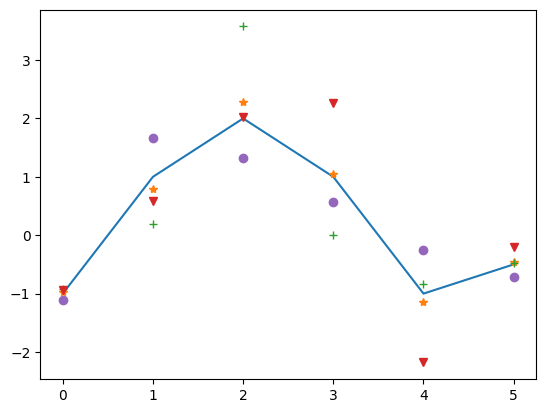

In [260]:
xleft = 0.0
xright = 2.0
n = 24
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))



coefs = np.array ([-1, 1, 2, 1,-1,-0.5])
m = len(coefs)- 1

print ('Коэффициенты точные', coefs)
print()

for i in range (0, m+1):
    yf += coefs[i]*x**i
#plt.plot (x,yf, 'o')

Delta = 0.1 * np.random.randn(len(x)) # случайные числа генерируются по нормальному распределению, E=0, среднее отклонение=1
y = yf + Delta
#plt.plot (x, y, '*')


print("x = ", x)
print("y = ", y)
print("m = ", m)

PolynomCoefs = SqLeast (x, y, m)
print ('Коэффициенты МНК', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
print ('Число обусловленности', cond)

print()

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
        
#plt.plot (x, y, 'o')
#plt.plot (x, PolynomValue)
#plt.subplot (x, ErrorLocal)

CoefsRegRidge = SqLeastRegRidge (x, y, m, 0.01)
print ('Коэффициенты МНК с L2 регуляризацией', CoefsRegRidge)
cond = np.linalg.cond (G)
print ('Число обусловленности', cond)
print()

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += CoefsRegRidge[i]*x**i
#plt.plot (x, PolynomValue)

CoefsRegLasso = SqLeastRegLasso (x, y, m, 0.01)
print ('Коэффициенты МНК с L1 регуляризацией', CoefsRegLasso)
cond = np.linalg.cond (G)
print ('Число обусловленности', cond)
print()

PhiInv = np.linalg.pinv(Phi, rcond = 1e-2)
CoefsSVD = PhiInv @ y
print ('Коэффициенты МНК SVD', CoefsSVD )
print()

U, s, Vh = np.linalg.svd(Phi)
print ('Сингулярные числа', s)

plt.plot (coefs)
plt.plot (CoefsRegRidge, '*')
plt.plot (CoefsRegLasso, '+')
plt.plot (PolynomCoefs, 'v')
plt.plot (CoefsSVD, 'o')

## Квазиреальный эксперимент 2. Линейная m-мерная регрессия.

In [261]:
n=100; m=3

Xm = np.zeros((n,m))

Xm[:,0] = np.random.random(n)
Xm[:,1] = np.random.random(n)
Xm[:,2] = 1.*Xm[:,0] + 1.* Xm [:,1] + 0.001 * np.random.randn(n)   # create bad condition
#Xm[:,2] = np.random.random(n)

coefs = np.array ([1, 0, 1])
yf = np.dot(Xm,coefs) 
y = yf + 0.01 * np.random.randn(n)
print ('y_error', (np.sum(yf-y)**2)**0.5)
print ()

#print (Xm)
print ('condition', np.linalg.cond(Xm))
#print ()

CoefsSq = SqLeast_mD (Xm, y)

CoefsLasso = SqLeast_mD_Lasso (Xm, y, 0.001)

CoefsRidge = SqLeast_mD_Ridge (Xm, y, 0.001)

PhiInv = np.linalg.pinv(Phi, rcond = 1.e-3)
CoefsSVD = PhiInv @ y

ypredictSq = np.dot(Phi, CoefsSq)
ypredictRidge = np.dot(Phi, CoefsRidge)
ypredictLasso = np.dot(Phi, CoefsLasso)
ypredictSVD = np.dot(Phi, CoefsSVD)

print ('Linear Model Parameters')
print ('Exact', coefs)
print ('SqLeast', CoefsSq)
print ('Ridge', CoefsRidge)
print ('Lasso', CoefsLasso)
print ('SVD', CoefsSVD)
#print (ypredict)

print ()

print ('RSS Sq', (np.sum(ypredictSq-y)**2)**0.5)
print ('RSS Ridge', (np.sum(ypredictRidge-y)**2)**0.5)
print ('RSS Lasso', (np.sum(ypredictLasso-y)**2)**0.5)
print ('RSS SVD', (np.sum(ypredictSVD-y)**2)**0.5)

print ()

print ('Error Sq', (np.sum(CoefsSq-coefs)**2)**0.5)
print ('Error Ridge', (np.sum(CoefsRidge-coefs)**2)**0.5)
print ('Error Lasso', (np.sum(CoefsLasso-coefs)**2)**0.5)
print ('Error SVD', (np.sum(CoefsSVD-coefs)**2)**0.5)

y_error 0.06658194769146661

condition 2270.3664726697134
Linear Model Parameters
Exact [1 0 1]
SqLeast [ 0.69711207 -0.29146938  1.29664258]
Ridge [ 0.98428966 -0.00423868  1.00948285]
Lasso [ 9.88521759e-01 -1.94273543e-06  1.00524928e+00]
SVD [0.99406299 0.00538753 0.99979426]

RSS Sq 0.029779770297265806
RSS Ridge 0.02795670231598804
RSS Lasso 0.027951429427651497
RSS SVD 0.0287195932182443

Error Sq 0.2977147364013675
Error Ridge 0.010466168624911763
Error Lasso 0.006230903613858965
Error SVD 0.000755228906937154


## Домашняя работа(собственная реализация)

In [262]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast_custom(x, y, m):
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a, G

def SqLeastRegRidge_custom(x, y, m, alpha):
    
    # polinomial approximation with L2 (Tikhonov) regularization
    # x, y - data set
    # m - polinom degree 

    # Полиномиальная аппроксимация с L2 (Ridge) регуляризацией
    # alpha - параметр регуляризации, уменьшает переобучение
    
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye(m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a, G


def SqLeastRegLasso_custom(x, y, m, alpha):
    
    # polinomial approximation with L1 (lasso) regularization
    # x, y - data set
    # m - number of basis functions (polinom degree + 1)
    
    n = len(x)
    yr = np.eye (n)
    E = np.eye (n)
    W = np.eye (m+1)
    
    
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    # initial stage
          
    G = PhiT @ Phi 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    yr = y @ E 
    
    eps = 0.001
    
    # iteration procedure
    
    for it in range (0, 20):
    
        ait = a            
          
        for j in range (0, m+1):
            W[j,j]=1./abs(ait[j]) #**2
           
                    
        RegAlpha = W * alpha
        G = PhiT @ Phi + RegAlpha
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
        # print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            break 
                
    return a, G


def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun      

Постановка задачи: есть n точек (x, y), которые соответствуют полиному с коэфицентами coefs. Далее зашумляем y-ки. И рассматриваем построение приближающей функции методом наименьших квадратов с регуляризацией и без. Регуляризация должна помочь упростить решение, но схватить общий вид.

In [263]:
xleft = 0.0
xright = 2.0
n = 24
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))



coefs = np.array ([-1, 1, 2, 1,-1,-0.5])
m = len(coefs)- 1

print ('Коэффициенты точные', coefs)
print()

for i in range (0, m+1):
    yf += coefs[i]*x**i
#plt.plot (x,yf, 'o')

Delta = 0.1 * np.random.randn(len(x)) # случайные числа генерируются по нормальному распределению, E=0, среднее отклонение=1
y = yf + Delta
#plt.plot (x, y, '*')


Коэффициенты точные [-1.   1.   2.   1.  -1.  -0.5]



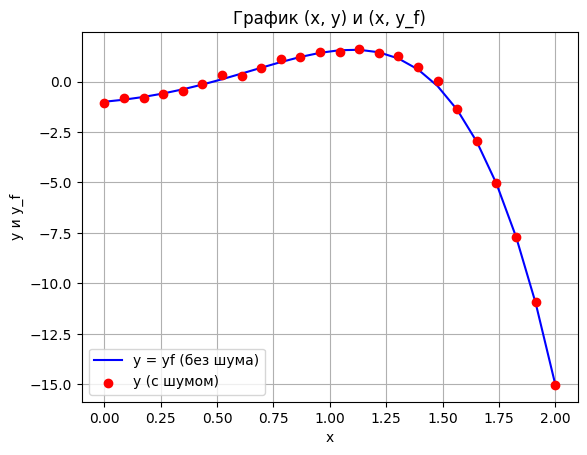

In [264]:
# n = 50
# m = 3

# np.random.seed(42)
# x = np.linspace(0, 1, n)
# yf = np.sin(2 * np.pi * x)
# y = yf + 0.1 * np.random.randn(n)


# Построение графика
plt.plot(x, yf, label='y = yf (без шума)', color='blue')
plt.scatter(x, y, color='red', label='y (с шумом)', zorder=2)
plt.xlabel('x')
plt.ylabel('y и y_f')
plt.legend()
plt.title('График (x, y) и (x, y_f)')
plt.grid(True)
plt.show()

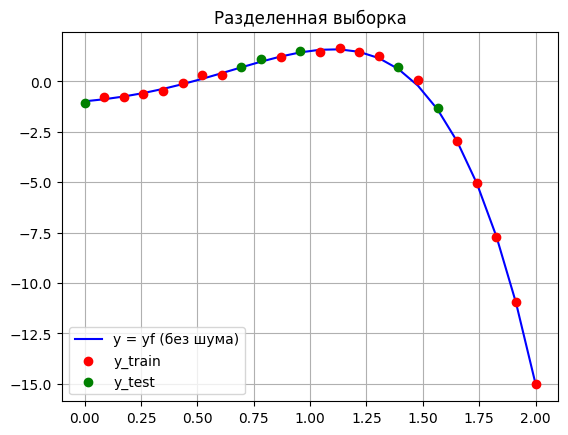

In [265]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

plt.plot(x, yf, label='y = yf (без шума)', color='blue')
plt.scatter(x_train, y_train, color='red', label='y_train', zorder=2)
plt.scatter(x_test, y_test, color='green', label='y_test', zorder=2)
plt.legend()
plt.title('Разделенная выборка')
plt.grid(True)
plt.show()

Коэффициенты МНК [-0.97030202  1.12435354  0.98247299  2.50689925 -1.75700531 -0.38121231]
Число обусловленности 32826209.82899201


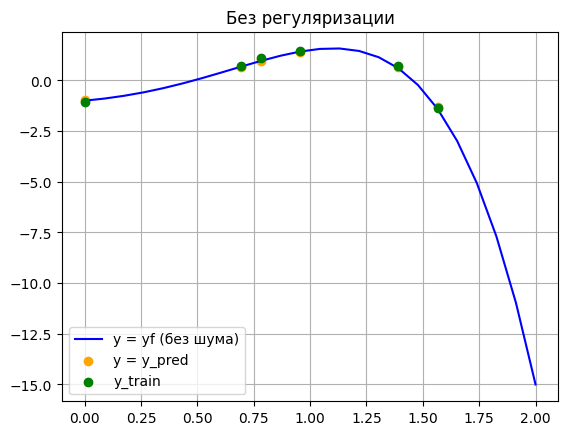

In [266]:
PolynomCoefs, G = SqLeast_custom(x_train, y_train, m)
print('Коэффициенты МНК', PolynomCoefs)

cond = np.linalg.cond(G)
print('Число обусловленности', cond)

y_pred = np.zeros(len(x_test))
for i in range(m + 1):
    y_pred += PolynomCoefs[i] * x_test**i


plt.plot(x, yf, label='y = yf (без шума)', color='blue')
sorted_indx = np.argsort(x_test)
plt.scatter(x_test[sorted_indx], y_pred[sorted_indx], label='y = y_pred', color='orange')
plt.scatter(x_test, y_test, color='green', label='y_train', zorder=2)
plt.legend()
plt.title('Без регуляризации')
plt.grid(True)
plt.show()

Коэффициенты МНК [-0.91076707  0.46602277  3.02210418  0.00821317 -0.44524974 -0.62843126]
Число обусловленности 354668.72540610115


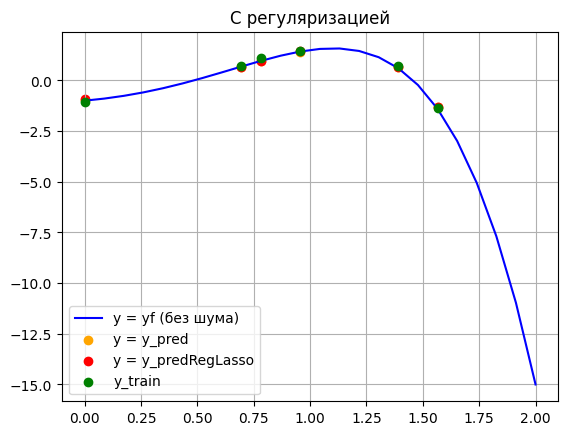

In [267]:
PolynomCoefsRegLasso, G = SqLeastRegLasso_custom(x_train, y_train, m, 0.001)
print('Коэффициенты МНК', PolynomCoefsRegLasso)

cond = np.linalg.cond(G)
print('Число обусловленности', cond)

y_predRegLasso = np.zeros(len(x_test))
for i in range(m + 1):
    y_predRegLasso += PolynomCoefsRegLasso[i] * x_test**i


plt.plot(x, yf, label='y = yf (без шума)', color='blue')
plt.scatter(x_test[sorted_indx], y_pred[sorted_indx], label='y = y_pred', color='orange')
plt.scatter(x_test[sorted_indx], y_predRegLasso[sorted_indx], label='y = y_predRegLasso', color='red')
plt.scatter(x_test, y_test, color='green', label='y_train', zorder=2)
plt.legend()
plt.title('С регуляризацией')
plt.grid(True)
plt.show()

### Подбор гиперпараметров: Grid Search (поиск по сетке)

#### Метрики

In [268]:
def MSE(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean((y_true - y_pred) ** 2)

In [269]:
def custom_grid_search(x, y, Model, degree, alphas):
    best_alpha = None
    best_score = float('inf')  # Начальное значение для лучшей ошибки
    

   
    for alpha in alphas:
        coefs, G = Model(x, y, degree, alpha)

        y_pred = np.zeros(len(x))
        for i in range(degree + 1): 
            y_pred += coefs[i] * x ** i
        
        # Число обусловленности
        cond = np.linalg.cond(G)
        score = MSE(y_pred, y)
        print(f"alpha={alpha} -> cond={cond}, MSE={score}")

        # Сравнение с лучшей ошибкой
        if score < best_score:
            best_score = score
            best_alpha = alpha



In [270]:
# Задаем диапазоны гиперпараметра
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Параметры регуляризации

print("L2 регуляризация")
custom_grid_search(x, y, SqLeastRegRidge_custom, m, alphas)


print("\nL1 регуляризация")
custom_grid_search(x, y, SqLeastRegLasso_custom, m, alphas)

L2 регуляризация
alpha=0.0001 -> cond=9341164.70933249, MSE=0.007099959911631162
alpha=0.001 -> cond=2914181.305431951, MSE=0.007137470532339252
alpha=0.01 -> cond=369807.63413100096, MSE=0.007296257263108633
alpha=0.1 -> cond=38003.90441992028, MSE=0.009551473180721725
alpha=1 -> cond=3811.8245448450075, MSE=0.04556929907680982
alpha=10 -> cond=382.1881167987363, MSE=0.392892643854119

L1 регуляризация
alpha=0.0001 -> cond=10083059.095209602, MSE=0.007096510311441516
alpha=0.001 -> cond=3215822.1387748686, MSE=0.007153090166019264
alpha=0.01 -> cond=134616.8427868693, MSE=0.007304271253353492
alpha=0.1 -> cond=1024182933.5668017, MSE=0.008527015181564047
alpha=1 -> cond=1266727889.2106051, MSE=0.05190201786318699
alpha=10 -> cond=54708231.36256734, MSE=0.7210285577377751


#### Сравним модели с L1, L2- регулярицациями и без регуляризации с исходной функцией

Без регуляризации
Число обусловленности: 1196154627.9820893
MSE(без шума) 2.0096485911251896
MSE(с шумом) 3.8568629396360695e-18
Коэффициенты [  -1.06435498  -31.68358205  128.08812774 -174.57092899  104.16979001
  -23.45039914]

L2 регуляризация
Число обусловленности: 207255.2153674255
MSE(без шума) 1.9998484510632097
MSE(с шумом) 0.0017448121433994992
Коэффициенты [-1.06296805  1.53901914  1.39723514  0.68238227 -0.1417542  -0.83835872]

L1 регуляризация
Число обусловленности: 1053931752.4252353
MSE(без шума) 1.9899670932507814
MSE(с шумом) 0.0018289332613497012
Коэффициенты [-1.04663545e+00  1.25833892e+00  2.15720240e+00  7.62371688e-03
  7.84995721e-11 -8.05488736e-01]
[-1.   1.   2.   1.  -1.  -0.5]


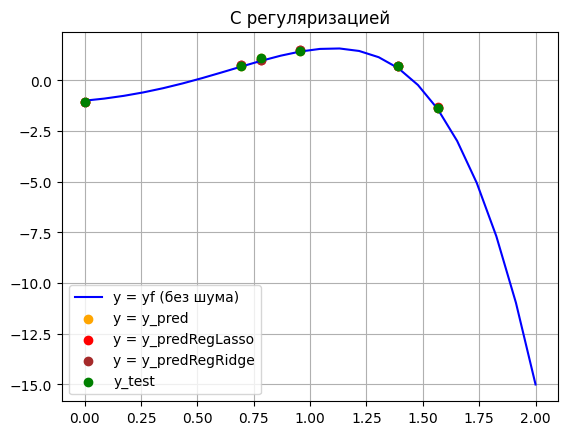

In [271]:
y_true = np.sin(2 * np.pi * x_test)

PolynomCoefs, G = SqLeast_custom(x_test, y_test, m)
PolynomCoefsRegRidge, GRegRidge = SqLeastRegRidge_custom(x_test, y_test, m, 0.001)
PolynomCoefsRegLasso, GRegLasso = SqLeastRegLasso_custom(x_test, y_test, m, 0.01)

y_pred = np.zeros(len(x_test))
y_predRegRidge = np.zeros(len(x_test))
y_predRegLasso = np.zeros(len(x_test))
for i in range(m + 1):
    y_pred += PolynomCoefs[i] * x_test**i
    y_predRegRidge += PolynomCoefsRegRidge[i] * x_test**i
    y_predRegLasso += PolynomCoefsRegLasso[i] * x_test**i


print("Без регуляризации")
print('Число обусловленности:', np.linalg.cond(G))
print('MSE(без шума)', MSE(y_pred, y_true))
print('MSE(с шумом)', MSE(y_pred, y_test))
print('Коэффициенты', PolynomCoefs)

print("\nL2 регуляризация")
print('Число обусловленности:', np.linalg.cond(GRegRidge))
print('MSE(без шума)', MSE(y_predRegRidge, y_true))
print('MSE(с шумом)', MSE(y_predRegRidge, y_test))
print('Коэффициенты', PolynomCoefsRegRidge)

print("\nL1 регуляризация")
print('Число обусловленности:', np.linalg.cond(GRegLasso))
print('MSE(без шума)', MSE(y_predRegLasso, y_true))
print('MSE(с шумом)', MSE(y_predRegLasso, y_test))
print('Коэффициенты', PolynomCoefsRegLasso)

print(coefs)

plt.plot(x, yf, label='y = yf (без шума)', color='blue')
plt.scatter(x_test[sorted_indx], y_pred[sorted_indx], label='y = y_pred', color='orange')
plt.scatter(x_test[sorted_indx], y_predRegLasso[sorted_indx], label='y = y_predRegLasso', color='red')
plt.scatter(x_test[sorted_indx], y_predRegRidge[sorted_indx], label='y = y_predRegRidge', color='brown')
plt.scatter(x_test, y_test, color='green', label='y_test', zorder=2)
plt.legend()
plt.title('С регуляризацией')
plt.grid(True)
plt.show()

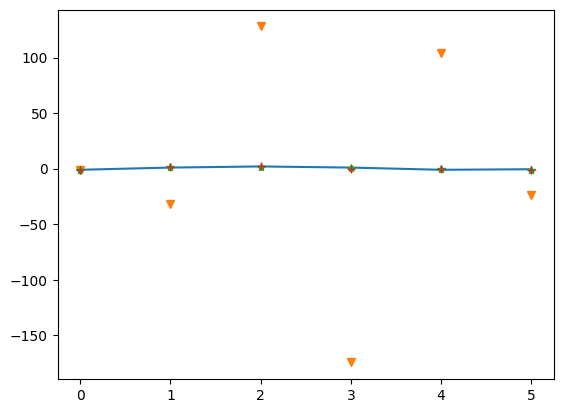

In [272]:
plt.plot (coefs)
plt.plot (PolynomCoefs, 'v')
plt.plot (PolynomCoefsRegRidge, '*')
plt.plot (PolynomCoefsRegLasso, '+')


Без регуляризации
Число обусловленности: 22052.9532358505
MSE(без шума) 0.005452180762023764
MSE(с шумом) 0.01037328040086561
Коэффициенты [ -0.41109153  13.80460074 -38.13387292  24.97204394]

L2 регуляризация
Число обусловленности: 10655.360298579151
MSE(без шума) 0.04296494660667716
MSE(с шумом) 0.053574596335879424
Коэффициенты [  0.63039021   4.82690881 -18.69667157  13.09640516]

L1 регуляризация
Число обусловленности: 13182.529397973587
MSE(без шума) 0.02241808656214508
MSE(с шумом) 0.03147537230471107
Коэффициенты [  0.32285468   7.50618887 -24.54557376  16.6899818 ]